# Analyse Range/Rssi/WlsError Charecteristics 

In [1]:
import pandas as pd
import numpy as np
import math

from pathlib import Path
import matplotlib.pyplot as plt 
import matplotlib.lines as lines

from matplotlib import cm

import MySimulationHelpers as mhf
#import MyMLHelperFunctions as mmlf



In [2]:
def plotNetwork(txy,pxy,xyobs,fig):
    #fig, ax = plt.subplots()
    #fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(txy[:,1],txy[:,2],s=80)
    for i, tid in enumerate(txy[:,0]):
        ax.annotate(tid, xy=(txy[i,1], txy[i,2]), xytext=(2,2), textcoords="offset points")

    for oid,a,b,c,d in xyobs:
        l1 = lines.Line2D([a, c], [b, d], lw=2, color='black', axes=ax)
        ax.annotate("obs-"+str(oid), xy=((a+c)/2, (b+d)/2))
        ax.add_line(l1)
        
    ax.scatter(pxy[:,0],pxy[:,1],s=2,c='red')

    ax.grid()
#     ax.set_xlim(0,1000)
#     ax.set_ylim(0,1000)
    ax.set_aspect('equal')
#    plt.show()


DEBUG::generateRealTimeMeasurements input speed/step-size = 50
DEBUG:: getTrajectory input speed/step-size = 50
Special traj_99...  meshgrid of step-size 50, shape (441, 2)


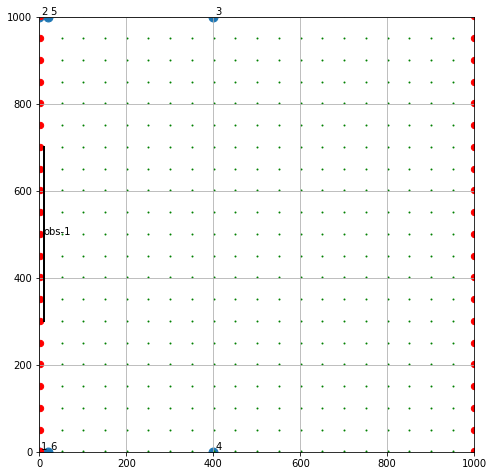

Generating Meas Data file ('data\deployment_3\traj_99\meas_data_99.csv')...
...DONE 440.0, Tx = [ 6 20  0] 		 99.8% 99.7%
Generating Meas DataOut file ('data\deployment_3\traj_99\meas_data_out_99.csv')...
Generating Estimated Position file ('data\deployment_3\traj_99\est_pos_99.csv')...


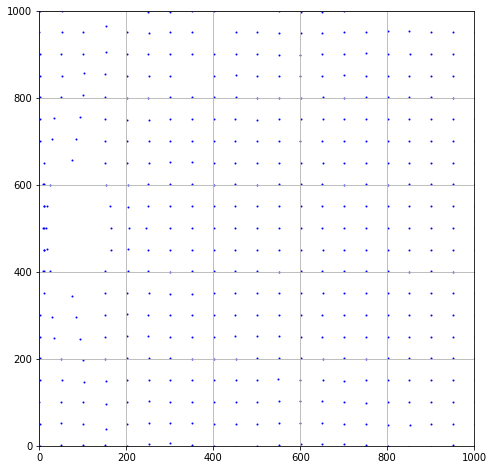

...DONE


In [8]:
networkIdx = 3
trajIdx = 99
verbosity = 2
SPEED = 50
mlModelH5Fname = "Dummy.h5"

truthCsvFname,measOutCsvFname,estPosCsvFname = mhf.generateRealTimeMeasurements(networkIdx, trajIdx, verbosity, speed=SPEED)
   
#mmlf.trainMlModelOnDataset(networkIdx,trajIdx,verbosity,mlModelH5Fname)

#truthCsvFname,measOutCsvFname,estPosCsvFname = mhf.generateRealTimeMeasurements(trajIdx,verbosity)


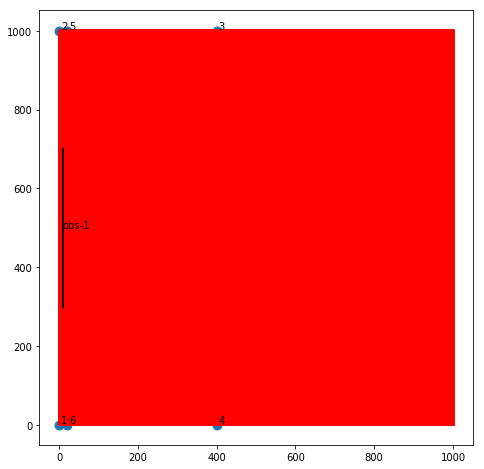

In [9]:
# Input filenames
txPosCsvFname = "data\\deployment_{0!s}\\{1}.csv".format(networkIdx, "txpos")
obsCsvFname = "data\\deployment_{0!s}\\{1}.csv".format(networkIdx, "obstacles")

fig = plt.figure(figsize=(8, 8))
txy,xyobs = mhf.getNetworkGeometry(txPosCsvFname, obsCsvFname, fig, 2)

df = pd.read_csv(truthCsvFname)
pxy = df.loc[:,['x','y']].values

fig.clf()

plotNetwork(txy,pxy,xyobs,fig)

ax = fig.gca()
ax.grid()
plt.show()


In [10]:
df = pd.read_csv(measOutCsvFname)
df['range_residual'] = df.range - df.dlos
df.head(10)

,timestamp,tid,tx,ty,range,rssi,los,dlos,nlos,residual,range_residual
0,0.0,1.0,0.0,0.0,1.0,0.840873,1.0,1.414214,0.0,-0.008729,-0.414214
1,0.0,2.0,0.0,1000.0,999.0,0.063274,1.0,999.000501,1.0,-0.319277,-0.000501
2,0.0,3.0,400.0,1000.0,1076.0,0.030489,1.0,1075.733238,0.0,-0.044721,0.266762
3,0.0,4.0,400.0,0.0,399.0,0.050063,1.0,399.001253,0.0,-0.005200,-0.001253
4,0.0,5.0,20.0,1000.0,-99.0,0.000000,0.0,999.180664,0.0,0.000000,-1098.180664
5,0.0,6.0,20.0,0.0,19.0,0.229257,1.0,19.026298,0.0,-0.114475,-0.026298
6,1.0,1.0,0.0,0.0,51.0,0.140015,1.0,51.009803,0.0,0.015566,-0.009803
7,1.0,2.0,0.0,1000.0,1000.0,0.031618,1.0,1000.300955,0.0,0.002236,-0.300955
8,1.0,3.0,400.0,1000.0,1058.0,0.030741,1.0,1058.206974,0.0,0.008426,-0.206974
9,1.0,4.0,400.0,0.0,349.0,0.053529,1.0,349.001433,0.0,-0.007907,-0.001433


[  4 400   0]
      tx   ty
3  400.0  0.0
(1002001, 2) [400   0]
(1002001,)
(1002001,)


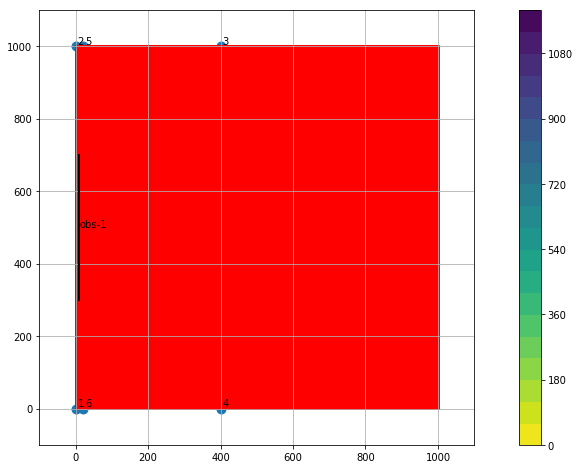

In [11]:
nsize = int(np.sqrt(pxy.shape[0]))
if nsize**2!=pxy.shape[0]:
    print("ERROR: input points data NOT a meshgrid...")

#idx = df[(df.tid==4) & (df.range>0)].index.tolist()
idx = df[(df.tid==4)].index.tolist()
rng = np.array([df.iloc[idx].range])
dlos = np.array([df.iloc[idx].dlos])
# rng_res = rng - dlos

print(txy[3,:])
print(df.loc[(df.tid==4)&(df.timestamp==0),['tx','ty']])

free_range = np.linalg.norm(pxy-txy[3,1:].transpose(),axis=1)
print(pxy.shape,txy[3,1:])
print(free_range.shape)
#rng_res = np.array([df.iloc[idx].range_residual])

rng_res = free_range

print(rng_res.shape)

X = pxy[:,0].reshape(nsize,-1)
Y = pxy[:,1].reshape(nsize,-1)
Z = rng_res.reshape(nsize,-1)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()#projection="3d")

ctr = ax.contourf(X, Y, Z, 20, cmap=cm.viridis_r)
#ctr = ax.contourf(X, Y, Z[:,:,1], 25, cmap=cm.RdGy)
fig.colorbar(ctr)
    
ax.set_aspect('equal')

plotNetwork(txy,pxy,xyobs,fig)
ax.set_xlim(-100,1100)
ax.set_ylim(-100,1100)
plt.show()

# ax.view_init(90, -90)

In [ ]:
df = pd.read_csv(estPosCsvFname)
df.head()

In [ ]:
tempxy = np.array([301.,201.,])
generateMeasurements(txy,tempxy,xyobs,"temp.csv",1000,3)



In [ ]:
temp = np.array([1.0,3.,1])
print(temp)
temp2 = np.array([])
print(temp2)
print(np.hstack((temp,temp2)))

In [ ]:
mlModelH5Fname = "MyMLModel99.h5"

networkIdx = 1
trajIdx = 99
verbosity = 3

mlEstPosCsvFname = mmlf.testMlModelOnDataset(mlModelH5Fname, networkIdx, trajIdx, verbosity, speed=50)


In [ ]:
df = pd.read_csv(mlEstPosCsvFname)
df.head()

In [ ]:
df = pd.read_csv(mlEstPosCsvFname)
df.head()

mxy = df.loc[:,['mlx','mly']].values
err = mxy - pxy
errn = np.linalg.norm(err,axis=1)

exy_s =  pxy + (1/QUIVER_SF) * err

print(mxy.shape,pxy.shape,err.shape,errn.shape)

Zn = errn.reshape(nsize,nsize)
Z = err.reshape(nsize,nsize,2)
print(X.shape,Y.shape,Z.shape,Zn.shape)

fig = plt.figure(figsize=(16,8))
plt.subplot(121)
ax = fig.gca()
ctr = ax.contourf(X, Y, Zn, 25, cmap=cm.viridis_r)
fig.colorbar(ctr, extend='both')
ax.set_aspect('equal')
plotNetwork(txy,pxy,xyobs,fig)

plt.subplot(122)
ax = fig.gca()
Q = plt.quiver(X, Y, Z[:,:,0], Z[:,:,1], units='xy', scale_units='xy', scale=QUIVER_SF, color='blue')
ax.scatter(exy_s[:,0],exy_s[:,1],s=2,c='green')
plotNetwork(txy,pxy,xyobs,fig)
ax.set_aspect('equal')

ax.set_xlim(-100,1100)
ax.set_ylim(-100,1100)
plt.show()
# ax.view_init(90, -90)



In [ ]:
networkIdx = 2
trajIdx = 1

# Input filenames
txPosCsvFname = "data\\deployment_{0!s}\\{1}.csv".format(networkIdx, "txpos")
obsCsvFname = "data\\deployment_{0!s}\\{1}.csv".format(networkIdx, "obstacles")
trajCsvFname = "data\\deployment_{0!s}\\{2}_{1!s}.csv".format(networkIdx, trajIdx, "waypoints")

if not Path(txPosCsvFname).is_file():
    print("Transmitter Position file \"{}\" DOES NOT exists!".format(txPosCsvFname))
if not Path(obsCsvFname).is_file():
    print("Obstable Position file \"{}\" DOES NOT exists!".format(obsCsvFname))
if not Path(trajCsvFname).is_file():
    print("Trajectory Waypoint file \"{}\" DOES NOT exists!".format(trajCsvFname))

fig = plt.figure(figsize=(8, 8))
txy,xyobs = mhf.getNetworkGeometry(txPosCsvFname, obsCsvFname, fig, 3)
pxy = mhf.getTrajectory(trajCsvFname, fig, speed=10, verb=3)

ax = fig.gca()
ax.grid()
plt.show()


In [ ]:
dft = pd.read_csv(truthCsvFname)
pxy = dft.loc[:,['x','y']].values
dft.head()

In [ ]:
dfe = pd.read_csv(estPosCsvFname)
exy = dfe.loc[:,['x','y']].values
err = pxy - exy
errn = np.linalg.norm(err,axis=1)

dfe['errx'] = pd.DataFrame(err[:,0])
dfe['erry'] = pd.DataFrame(err[:,1])
dfe['err'] = pd.DataFrame(errn)
nepoch = int(dfe.iloc[-1].timestamp + 1)
dfe.head()

In [ ]:
df = pd.read_csv(measOutCsvFname)
df['range_residual'] = df.range - df.dlos
df['rssi_truth'] = 1/ np.sqrt(df.dlos) # np.log(df.dlos/df.range)# - np.log(1 + 1/np.sqrt(df.dlos))
df['rssi_residual'] = df.rssi * np.sqrt(df.dlos)  # np.log(df.dlos/df.range)# - np.log(1 + 1/np.sqrt(df.dlos))
df['rssi_residual2'] = 100*np.log(df.rssi * np.sqrt(df.dlos) )
df.head(10)

In [ ]:
rr = df.loc[(df.tid==3),'range_residual']
fig = plt.figure(figsize=(16,6))
plt.plot(pxy[:,0],rr,'o')
plt.xlim(5,450)
plt.grid()

In [ ]:
fig = plt.figure(figsize=(16,6))
plt.plot(exy[:,0],exy[:,1],'o')
plt.xlim(5,250)
plt.ylim(498,502)
plt.grid()

In [ ]:
fig = plt.figure(figsize=(16,6))
plt.plot(pxy[:,0],err[:,0],'o')
plt.xlim(5,450)
plt.ylim(-60,60)
plt.grid()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot(pxy[:,0],exy[:,0],'o')
plt.plot(pxy[:,0],pxy[:,0],'-')
plt.xlim(5,450)
plt.ylim(5,450)
plt.grid()

In [ ]:
NUM_SV = 20
NUM_FEATURE_POS = 3
NUM_FEATURE_PER_SV = 4
NUM_FEATURE = NUM_FEATURE_POS + NUM_SV * NUM_FEATURE_PER_SV

#fig.clf()
#idx = dfe.loc[(dt.err<10.)]

normalize_wrt_bias = 1

netbf = np.zeros((NUM_SV+1,2))
fig = plt.figure(figsize=(12,12))

idx = np.where((errn>100) & (errn<1000))
print(idx[0].shape)
for t in idx[0]:#np.arange(1,20):#nepoch):
    bf = np.zeros((NUM_SV,2))
    ang = math.atan2(err[t,1],err[t,0])
    print("Epoch {}, error = {}, angle = {}".format(t,errn[t],ang*180/np.pi))
    
    idx = 0
    starti=NUM_FEATURE_POS
    endi=starti+NUM_FEATURE_PER_SV
    for sid in np.arange(1,NUM_SV+1):
        tpos = df.loc[(df.timestamp==t)&(df.tid==sid),['tx','ty','range','rssi_residual2','range_residual']]
        az = math.atan2(exy[t,1]-tpos.ty,exy[t,0]-tpos.tx)
        #print("[{}]: tid={}, rr={}, az={}".format(t,sid,tpos.range_residual.values[0],az))
        bf[sid-1,0] = az
        if int(tpos.range)>0:
            tpos.rssi_residual2[tpos.rssi_residual2>0] = np.sqrt(tpos.rssi_residual2)
            bf[sid-1,1] = -1 * tpos.rssi_residual2
            #bf[sid-1,1] = tpos.range_residual
            #bf[sid-1,1] = np.log10(1 + tpos.range_residual) if int(tpos.range_residual)>0 else -np.log10(1-tpos.range_residual)
            #print("rr={}, fn={}".format(tpos.range_residual.values[0],bf[sid-1,1]))
    #print("before roll {}".format(np.floor(bf[:,0]*180/np.pi)))
    
    if normalize_wrt_bias==1:
        bf[:,0] = bf[:,0] - ang
        idx = np.where(bf[:,0]<-np.pi)
        bf[idx,0] = bf[idx,0] + 2*np.pi
        idx = np.where(bf[:,0]>np.pi)
        bf[idx,0] = bf[idx,0] - 2*np.pi
    
    #normalizeAndPolar(bf)
    
    #netbf = netbf + bf

    #print("before roll {}".format(np.floor(bf[:,0]*180/np.pi)))
    #print("before roll {}".format(bf[:,1]))
    #bf = np.roll(bf,-idx,axis=0)
    
#     print(np.floor(ang*180/np.pi),np.floor(bf[:,0]*180/np.pi))
    #print(np.floor(bf))
    
    #print("after roll {}".format(bf))
    #ax = fig.subplots(121)
    normalizeAndPolar(bf, fig, do_polar=True)
    #plt.polar(bf[:,0],bf[:,1],ls='-',marker='.')
    #plt.plot(bf[:,0],bf[:,1],ls='-',marker='.')
    
#     ax = fig.subplots(122)
#     plt.plot(bf[:,0],bf[:,1])

#print(bf)
#plt.grid()
plt.show()

print("before roll {}".format(np.floor(netbf[:,0]*180/np.pi)))


In [ ]:
from scipy.interpolate import interp1d

def normalizeAndPolar(bf, fig, do_polar=True, do_looparound=False):
    #bf = np.sort(bf, axis=-1)
    n = bf.shape[0]
    idx = np.argsort(bf,axis=0)[:,0]
    bf = bf[idx,:]
    #print(n,bf)
    
    xy = np.zeros((n+2,2))
    
    xy[0,0] = bf[-1,0]-2*np.pi
    xy[0,1] = bf[-1,1]
    xy[-1,0] = bf[0,0]+2*np.pi
    xy[-1,1] = bf[0,1]
    xy[1:-1,:] = bf
    
    #print(np.round(xy[:,0]*180/np.pi))
    #print(xy[:,0]*180/np.pi)
    
    #print(temp2.shape,temp2)
    #x = xy[:,0]
    #y = xy[:,1]

    f1 = interp1d(xy[:,0], xy[:,1])
    f2 = interp1d(xy[:,0], xy[:,1], kind='quadratic')

    if do_looparound:
        xnew = np.linspace(xy[0,0], xy[-1,0], num=901, endpoint=False)
    else:
        xnew = np.linspace(-np.pi, np.pi, num=901, endpoint=False)

    if do_polar:
        plt.polar(xy[:,0], xy[:,1], 'o', xnew, f1(xnew), '-')
        #plt.polar(xy[:,0], xy[:,1], 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
    else:
        plt.plot(xy[:,0], xy[:,1], 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
        plt.grid()
    #plt.legend(['data', 'linear', 'quadratic'], loc='best')
    #plt.show()

In [ ]:
normalizeAndPolar(bf, do_polar=True)

In [ ]:

n = bf.shape[0]
idx = np.argsort(temp,axis=0)[:,0]
bf = bf[idx,:]
#print(n,bf)
    
#bf = np.sort(bf, axis=-1)
temp = np.zeros((20,2))
temp[:,0] = bf[:,0]*180/np.pi
temp[:,1] = np.floor(bf[:,1])
print(temp)

In [ ]:
idx = np.argsort(temp,axis=0)[:,0]
temp = temp[idx,:]
temp2 = np.zeros((22,2))
temp2[0,0] = temp[-1,0]-360.
temp2[0,1] = temp[-1,1]
temp2[-1,0] = temp[0,0]+360.
temp2[-1,1] = temp[0,1]
temp2[1:-1,:] = temp
print(temp2.shape,temp2)
x = temp2[:,0]
y = temp2[:,1]

# print(x[1:])
# print(x[:-1])
# print(x[1:]-x[:-1])


In [ ]:
from scipy.interpolate import interp1d

f1 = interp1d(x, y)
f2 = interp1d(x, y, kind='quadratic')


In [ ]:
xnew = np.linspace(-180, 180, num=901, endpoint=True)

fig = plt.figure(figsize=(16,8))
plt.plot(x, y, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'quadratic'], loc='best')

plt.grid()
plt.show()


In [ ]:
fig = plt.figure(figsize=(12,12))
plt.polar(x*np.pi/180, y, 'o', xnew*np.pi/180, f1(xnew), '-', xnew*np.pi/180, f2(xnew), '--')
plt.legend(['data', 'linear', 'quadratic'], loc='best')



In [ ]:
te = np.array([-10,-8,-3,-1,2,5,9,12])
print(te)
te = te - 4
print(te)

In [ ]:
idx = np.where(te>0)
idx1 = idx[0][0]
print(idx,idx1)


In [ ]:
print(np.roll(te,-idx1))